<a href="https://colab.research.google.com/github/uygararas/ie423/blob/main/hck.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Libraries

In [91]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [92]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [93]:
# Load data into DataFrames
df_2020 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/hackathon/extracted_data2020.csv')
df_2021 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/hackathon/extracted_data2021.csv')
df_2023 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/hackathon/extracted_data2023.csv')

In [94]:
# Combine dataframes
df_combined = pd.concat([df_2020, df_2021, df_2023])

# Convert 'Total Rider' column to numeric, handling periods as thousands separators
df_combined['Total Rider'] = df_combined['Total Rider'].str.replace('.', '').astype(float)

# Ensure the date index is sorted and has a frequency
df_combined.index = pd.date_range(start='2020-01-01', periods=len(df_combined), freq='M')
df_combined = df_combined.sort_index().asfreq('M')

# Fill or interpolate missing values
df_combined['Total Rider'] = df_combined['Total Rider'].interpolate(method='linear')

        Total Rider
count  4.200000e+01
mean   3.971246e+07
std    4.462141e+07
min    0.000000e+00
25%    2.410441e+06
50%    1.957480e+07
75%    7.617638e+07
max    1.589906e+08


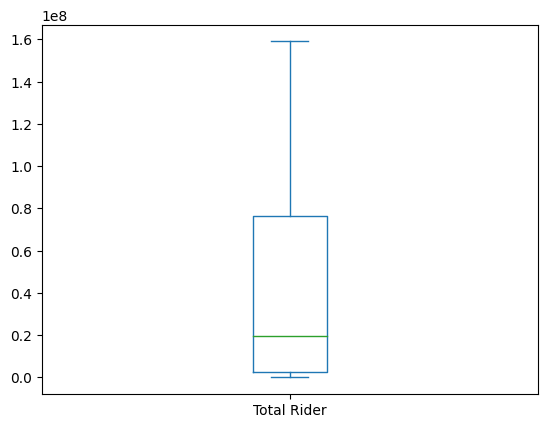

In [95]:
# Examine the data for extreme values or outliers
print(df_combined.describe())
df_combined['Total Rider'].plot(kind='box')
plt.show()

In [96]:
# Replace zeros with a small positive value before applying log transformation
df_combined['Total Rider'] = df_combined['Total Rider'].replace(0, 1)

# Remove outliers by capping the values at the 95th percentile
upper_limit = df_combined['Total Rider'].quantile(0.95)
df_combined['Total Rider'] = np.where(df_combined['Total Rider'] > upper_limit, upper_limit, df_combined['Total Rider'])

In [97]:
# Apply log transformation to stabilize variance
df_combined['Total Rider_log'] = np.log(df_combined['Total Rider'])

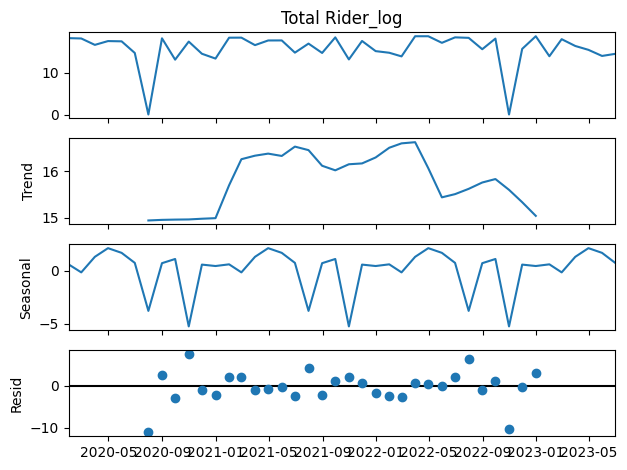

In [98]:
# Decompose the time series
result = seasonal_decompose(df_combined['Total Rider_log'], model='additive', period=12)
result.plot()
plt.show()

In [99]:
# Check if the data is stationary
adf_result = adfuller(df_combined['Total Rider_log'])
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])

ADF Statistic: -6.835835769833702
p-value: 1.843599986442277e-09


In [100]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA model
arima_model = ARIMA(df_combined['Total Rider_log'], order=(1, 1, 1))
arima_result = arima_model.fit()

print(arima_result.summary())

                               SARIMAX Results                                
Dep. Variable:        Total Rider_log   No. Observations:                   42
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -116.510
Date:                Thu, 25 Jul 2024   AIC                            239.020
Time:                        13:15:46   BIC                            244.161
Sample:                    01-31-2020   HQIC                           240.892
                         - 06-30-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0630      0.316     -0.200      0.842      -0.681       0.555
ma.L1         -0.9994     19.833     -0.050      0.960     -39.871      37.872
sigma2        15.6729    311.275      0.050      0.9

In [101]:
# Forecast for the next 5 years (60 months)
forecast_steps = 60
forecast = arima_result.get_forecast(steps=forecast_steps)
forecast_df = forecast.summary_frame(alpha=0.05)

# Reverse log transformation
forecast_df['mean'] = np.exp(forecast_df['mean'])
forecast_df['mean_ci_lower'] = np.exp(forecast_df['mean_ci_lower'])
forecast_df['mean_ci_upper'] = np.exp(forecast_df['mean_ci_upper'])

# Apply lower bound to ensure non-negative forecast
forecast_df['mean'] = forecast_df['mean'].apply(lambda x: max(x, df_combined['Total Rider'].min()))

forecast_index = pd.date_range(start=df_combined.index[-1] + pd.DateOffset(months=1), periods=forecast_steps, freq='M')

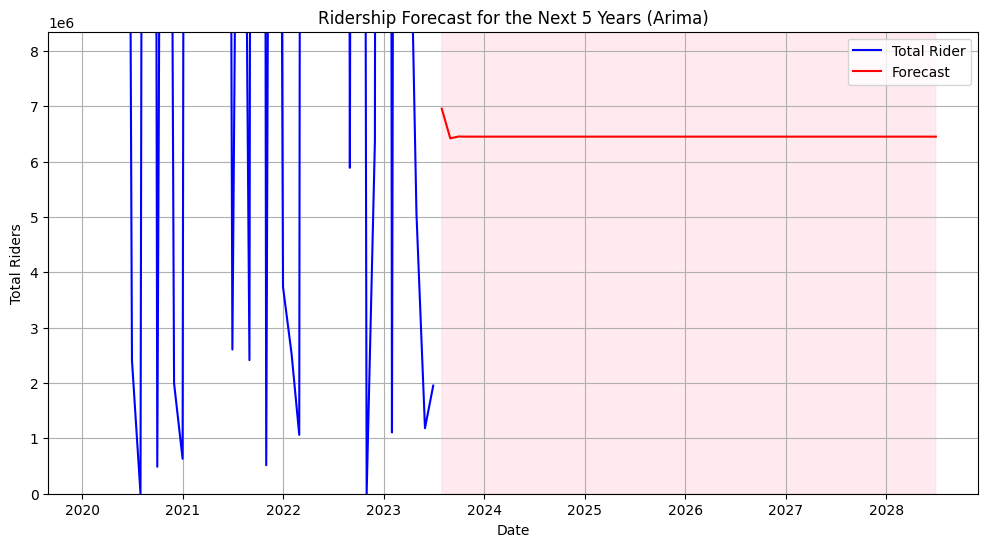

In [102]:
# Improved plot with better scaling
plt.figure(figsize=(12, 6))
plt.plot(df_combined.index, df_combined['Total Rider'], label='Total Rider', color='blue')
plt.plot(forecast_index, forecast_df['mean'], label='Forecast', color='red')
plt.fill_between(forecast_index, forecast_df['mean_ci_lower'], forecast_df['mean_ci_upper'], color='pink', alpha=0.3)
plt.ylim(bottom=0, top=forecast_df['mean'].max() * 1.2)  # Ensure the y-axis starts at 0 and is scaled properly
plt.title('Ridership Forecast for the Next 5 Years (Arima)')
plt.xlabel('Date')
plt.ylabel('Total Riders')
plt.legend()
plt.grid(True)
plt.show()

In [103]:
# Calculate required increase
current_ridership = df_combined['Total Rider'].iloc[-1]
future_ridership = forecast_df['mean'].iloc[-1]
predicted_increase = (future_ridership - current_ridership) / current_ridership * 100

print(f"Current Ridership: {current_ridership}")
print(f"Predicted Ridership in 5 Years: {future_ridership}")
print(f"Predicted Increase: {predicted_increase:.2f}%")

Current Ridership: 1953679.0
Predicted Ridership in 5 Years: 6452863.627794061
Predicted Increase: 230.29%


In [104]:
# Fit Exponential Smoothing model
ets_model = ExponentialSmoothing(df_combined['Total Rider'], seasonal='add', seasonal_periods=12).fit()

# Forecast for the next 5 years (60 months)
forecast_steps = 60
forecast = ets_model.forecast(steps=forecast_steps)
forecast_index = pd.date_range(start=df_combined.index[-1], periods=forecast_steps + 1, freq='M')[1:]

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


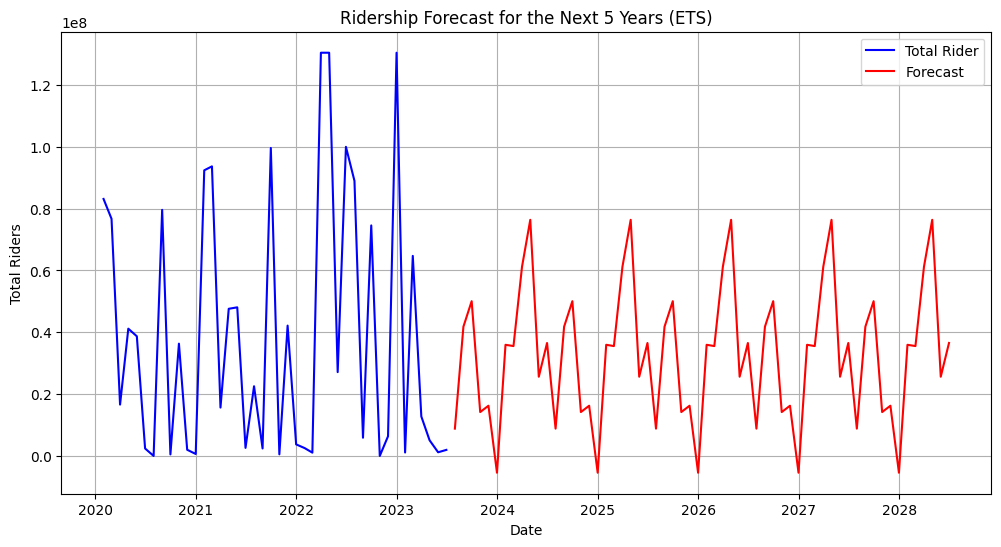

In [105]:
# Plot historical and forecast data
plt.figure(figsize=(12, 6))
plt.plot(df_combined.index, df_combined['Total Rider'], label='Total Rider', color='blue')
plt.plot(forecast_index, forecast, label='Forecast', color='red')
plt.title('Ridership Forecast for the Next 5 Years (ETS)')
plt.xlabel('Date')
plt.ylabel('Total Riders')
plt.legend()
plt.grid(True)
plt.show()

In [106]:
# Print forecasted data for ETS
forecast_df = pd.DataFrame(forecast, index=forecast_index, columns=['Forecast'])
print("ETS Forecast Data:")
print(forecast_df.head())

# Calculate required increase
current_ridership = df_combined['Total Rider'].iloc[-1]
future_ridership = forecast_df['Forecast'].iloc[-1]
predicted_increase = (future_ridership - current_ridership) / current_ridership * 100

print(f"Current Ridership: {current_ridership}")
print(f"Predicted Ridership in 5 Years: {future_ridership}")
print(f"Predicted Increase: {predicted_increase:.2f}%")

ETS Forecast Data:
                Forecast
2023-07-31  8.830589e+06
2023-08-31  4.181229e+07
2023-09-30  5.006654e+07
2023-10-31  1.419556e+07
2023-11-30  1.623897e+07
Current Ridership: 1953679.0
Predicted Ridership in 5 Years: 36537629.23646672
Predicted Increase: 1770.20%


In [107]:
# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df_combined[['Total Rider']])

In [109]:
# Prepare data for LSTM
def create_dataset(data, look_back=1):
    X, y = [], []
    for i in range(len(data) - look_back - 1):
        a = data[i:(i + look_back), 0]
        X.append(a)
        y.append(data[i + look_back, 0])
    return np.array(X), np.array(y)

look_back = 12
X, y = create_dataset(df_scaled, look_back)

# Reshape input to be [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

In [110]:
# Build and train LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(look_back, 1)))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X, y, epochs=20, batch_size=1, verbose=2)

Epoch 1/20
29/29 - 4s - loss: 0.1500 - 4s/epoch - 127ms/step
Epoch 2/20
29/29 - 0s - loss: 0.1346 - 224ms/epoch - 8ms/step
Epoch 3/20
29/29 - 0s - loss: 0.1317 - 221ms/epoch - 8ms/step
Epoch 4/20
29/29 - 0s - loss: 0.1350 - 218ms/epoch - 8ms/step
Epoch 5/20
29/29 - 0s - loss: 0.1315 - 219ms/epoch - 8ms/step
Epoch 6/20
29/29 - 0s - loss: 0.1247 - 218ms/epoch - 8ms/step
Epoch 7/20
29/29 - 0s - loss: 0.1273 - 227ms/epoch - 8ms/step
Epoch 8/20
29/29 - 0s - loss: 0.1289 - 214ms/epoch - 7ms/step
Epoch 9/20
29/29 - 0s - loss: 0.1390 - 220ms/epoch - 8ms/step
Epoch 10/20
29/29 - 0s - loss: 0.1274 - 225ms/epoch - 8ms/step
Epoch 11/20
29/29 - 0s - loss: 0.1322 - 219ms/epoch - 8ms/step
Epoch 12/20
29/29 - 0s - loss: 0.1366 - 221ms/epoch - 8ms/step
Epoch 13/20
29/29 - 0s - loss: 0.1254 - 214ms/epoch - 7ms/step
Epoch 14/20
29/29 - 0s - loss: 0.1328 - 209ms/epoch - 7ms/step
Epoch 15/20
29/29 - 0s - loss: 0.1277 - 210ms/epoch - 7ms/step
Epoch 16/20
29/29 - 0s - loss: 0.1281 - 204ms/epoch - 7ms/step
Ep

In [111]:
# Forecast for the next 5 years (60 months)
predictions = []

input_data = df_scaled[-look_back:]
input_data = input_data.reshape((1, look_back, 1))

for _ in range(60):
    pred = model.predict(input_data)
    predictions.append(pred[0][0])
    input_data = np.append(input_data[:, 1:, :], [[pred[0]]], axis=1)

predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

forecast_index = pd.date_range(start=df_combined.index[-1], periods=61, freq='M')[1:]

1/1 [==============================] - 0s 24ms/step


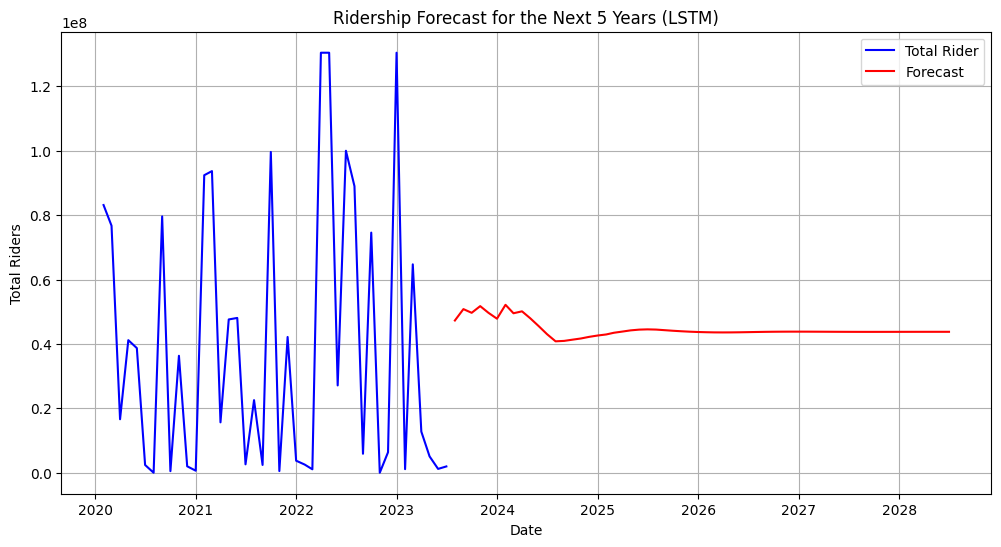

In [112]:
# Plot historical and forecast data
plt.figure(figsize=(12, 6))
plt.plot(df_combined.index, df_combined['Total Rider'], label='Total Rider', color='blue')
plt.plot(forecast_index, predictions, label='Forecast', color='red')
plt.title('Ridership Forecast for the Next 5 Years (LSTM)')
plt.xlabel('Date')
plt.ylabel('Total Riders')
plt.legend()
plt.grid(True)
plt.show()


In [113]:
# Print forecasted data for LSTM
forecast_df = pd.DataFrame(predictions, index=forecast_index, columns=['Forecast'])
print("LSTM Forecast Data:")
print(forecast_df.head())

# Calculate required increase
current_ridership = df_combined['Total Rider'].iloc[-1]
future_ridership = forecast_df['Forecast'].iloc[-1]
predicted_increase = (future_ridership - current_ridership) / current_ridership * 100

print(f"Current Ridership: {current_ridership}")
print(f"Predicted Ridership in 5 Years: {future_ridership}")
print(f"Predicted Increase: {predicted_increase:.2f}%")

LSTM Forecast Data:
              Forecast
2023-07-31  47272588.0
2023-08-31  50812688.0
2023-09-30  49664168.0
2023-10-31  51738692.0
2023-11-30  49665096.0
Current Ridership: 1953679.0
Predicted Ridership in 5 Years: 43765068.0
Predicted Increase: 2140.14%
